# Optical flow random image denoising VS [cv2.fastNlMeansDenoising()](https://docs.opencv.org/3.4/d5/d69/tutorial_py_non_local_means.html) (barb)

In [15]:
local_debug = True

In [1]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
#from ipywidgets import *
import cv2
import time
#import kernels
from skimage import io as skimage_io
from skimage.metrics import structural_similarity as ssim
from scipy import stats
import math

In [16]:
if local_debug:
    !ln -sf ../../information_theory/src/information_theory/ .
else:
    !pip install "information_theory @ git+https://github.com/vicente-gonzalez-ruiz/information_theory"
import information_theory  # pip install "information_theory @ git+https://github.com/vicente-gonzalez-ruiz/information_theory"

In [3]:
import denoising.image.OF_random as random_denoising

In [4]:
GT = skimage_io.imread("http://www.hpca.ual.es/~vruiz/images/barb.png")

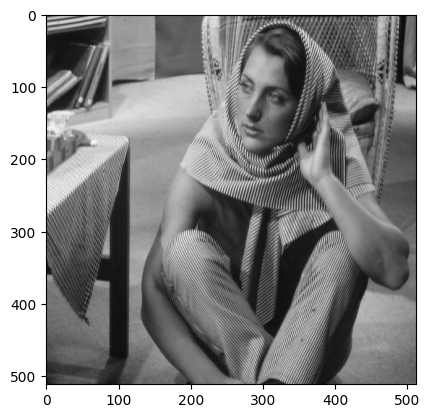

In [5]:
plt.imshow(GT, cmap="gray")

In [6]:
padded_GT = np.zeros(shape=(GT.shape[0]+32, GT.shape[1]+32), dtype=np.uint8)
padded_GT[16:-16, 16:-16] = GT
GT = padded_GT

In [7]:
mean = 0
var = 1000
sigma = 20 #var**0.5
noise = np.random.normal(mean, sigma, GT.shape).reshape(GT.shape)
noisy = np.clip(a=GT.astype(np.float32) + noise, a_min=0, a_max=255).astype(np.uint8)

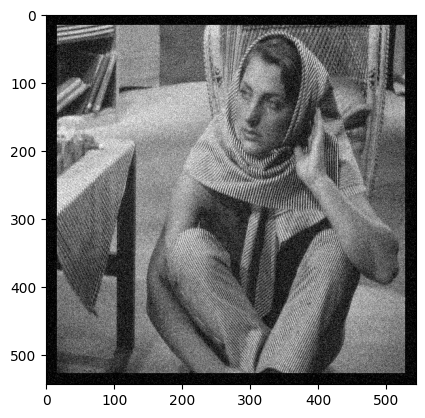

In [8]:
plt.imshow(noisy, cmap="gray")

## Low filtering level

In [12]:
denoised = cv2.fastNlMeansDenoising(noisy, None, h=23, templateWindowSize=3, searchWindowSize=9)

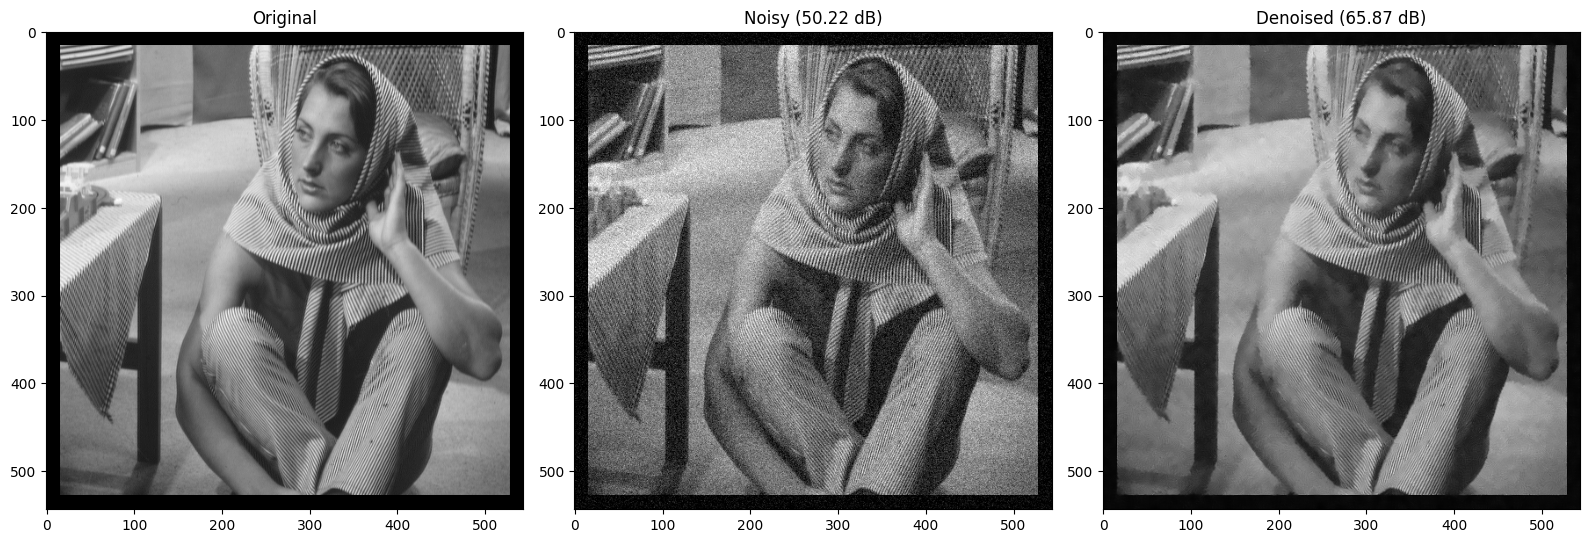

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(16, 32))
axs[0].imshow(GT, cmap="gray")
axs[0].set_title("Original")
axs[1].imshow(noisy, cmap="gray")
axs[1].set_title(f"Noisy ({information_theory.distortion.PSNR(noisy, GT):4.2f} dB)")
axs[2].imshow(denoised, cmap="gray")
axs[2].set_title(f"Denoised ({information_theory.distortion.PSNR(denoised, GT):4.2f} dB)")
fig.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(32, 32))
axs[0].imshow(noisy_img, cmap="gray")
axs[0].set_title(f"Noisy {ssim(img, noisy_img)}")
axs[1].imshow(denoised_img_fastNlMeans, cmap="gray")
axs[1].set_title(f"fastNlMeans {ssim(img, denoised_img_fastNlMeans)}")
axs[2].imshow(denoised_img, cmap="gray")
axs[2].set_title(f"RSIID {ssim(img, denoised_img.astype(np.uint8))}")
fig.tight_layout()
plt.show()

## Medium filtering level

In [23]:
denoised = cv2.fastNlMeansDenoising(noisy, None, h=25, templateWindowSize=7, searchWindowSize=9)

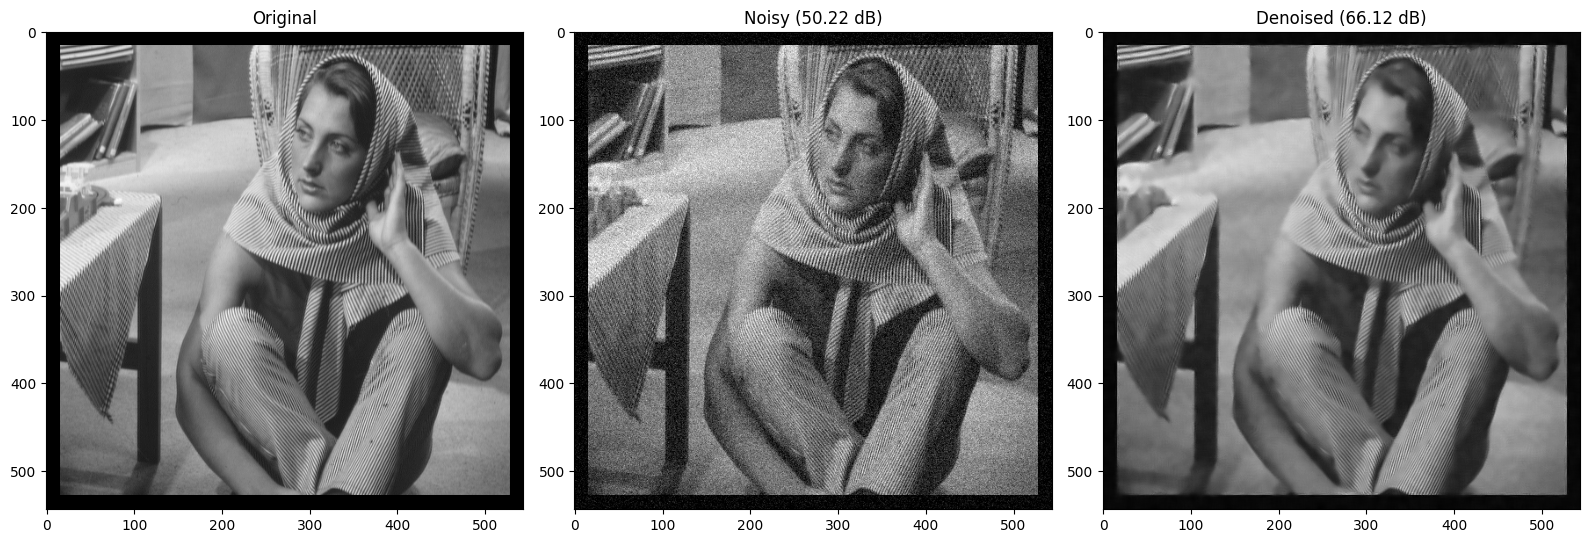

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(16, 32))
axs[0].imshow(GT, cmap="gray")
axs[0].set_title("Original")
axs[1].imshow(noisy, cmap="gray")
axs[1].set_title(f"Noisy ({information_theory.distortion.PSNR(noisy, GT):4.2f} dB)")
axs[2].imshow(denoised, cmap="gray")
axs[2].set_title(f"Denoised ({information_theory.distortion.PSNR(denoised, GT):4.2f} dB)")
fig.tight_layout()
plt.show()

## High filtering level

In [25]:
denoised = cv2.fastNlMeansDenoising(noisy, None, h=33, templateWindowSize=7, searchWindowSize=9)

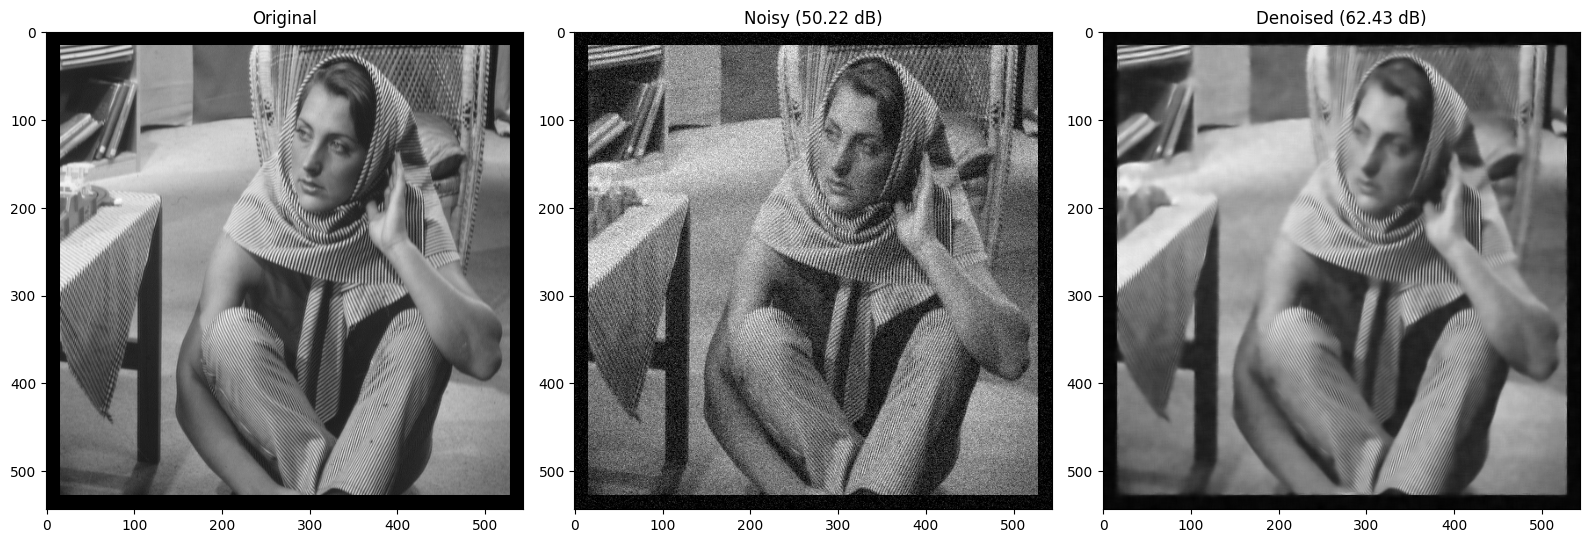

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(16, 32))
axs[0].imshow(GT, cmap="gray")
axs[0].set_title("Original")
axs[1].imshow(noisy, cmap="gray")
axs[1].set_title(f"Noisy ({information_theory.distortion.PSNR(noisy, GT):4.2f} dB)")
axs[2].imshow(denoised, cmap="gray")
axs[2].set_title(f"Denoised ({information_theory.distortion.PSNR(denoised, GT):4.2f} dB)")
fig.tight_layout()
plt.show()

In [ ]:
input()

## [Measurement of the denoising](http://faculty.ucmerced.edu/mhyang/papers/iccv13_denoise.pdf)

In [ ]:
def get_denoising_quality(img, denoised_img):
    diff_img = (img - denoised_img).astype(np.uint8)
    _, N = ssim(img, diff_img, full=True)
    #print(_)
    _, P = ssim(img, denoised_img.astype(np.uint8), full=True)
    #print(_)
    quality, _ = stats.pearsonr(N.flatten(), P.flatten())
    #print("quality", quality)
    if math.isnan(quality):
        return 0.0
    else:
        return -quality

## Optimization of the parameters of cv2.fastNlMeansDenoising()

In [ ]:
plt.imshow(cv2.fastNlMeansDenoising(img, None, h=14, templateWindowSize=7, searchWindowSize=21), cmap="gray")

In [ ]:
# Optimizing h
prev_quality = -1
for i in range(15, 30):
    #denoised_img = cv2.fastNlMeansDenoising(img, None, 11, 6, 7, 21)
    denoised_img = cv2.fastNlMeansDenoising(noisy_img, None, h=i, templateWindowSize=7, searchWindowSize=21)
    quality = get_denoising_quality(noisy_img, denoised_img)
    if prev_quality > quality:
        optimal_h = i - 1
        break
    plt.imshow(denoised_img, cmap="gray")
    plt.title(f"{i} {quality}")
    plt.show()
    prev_quality = quality

print("optimal h", optimal_h)

In [ ]:
# Optimizing templateWindowSize
prev_quality = -1
for i in range(2, 22):
    #denoised_img = cv2.fastNlMeansDenoising(img, None, 11, 6, 7, 21)
    denoised_img = cv2.fastNlMeansDenoising(noisy_img, None, h=23, templateWindowSize=i, searchWindowSize=21)
    quality = get_denoising_quality(noisy_img, denoised_img)
    if prev_quality > quality:
        optimal_templateWindowSize = i - 1
        break
    plt.imshow(denoised_img, cmap="gray")
    plt.title(f"{i} {quality}")
    plt.show()
    prev_quality = quality

print("optimal templateWindowSize", optimal_templateWindowSize)

In [ ]:
# Optimizing searchWindowSize
prev_quality = -1
for i in range(3, 33):
    #denoised_img = cv2.fastNlMeansDenoising(img, None, 11, 6, 7, 21)
    denoised_img = cv2.fastNlMeansDenoising(noisy_img, None, h=23, templateWindowSize=3, searchWindowSize=i)
    quality = get_denoising_quality(noisy_img, denoised_img)
    if prev_quality > quality:
        optimal_searchWindowSize = i - 1
        break
    plt.imshow(denoised_img, cmap="gray")
    plt.title(f"{i} {quality}")
    plt.show()
    prev_quality = quality

print("optimal searchWindowSize", optimal_searchWindowSize)

## Optimization of the parameters of RSIID

In [ ]:
# Optimizing RS_sigma
prev_quality = -1
for i in range(7, 30):
    _i = i/10
    denoiser = random_denoising.Filter_Monochrome_Image(l=3, w=7, poly_sigma=1.0, verbosity=logging.WARNING)
    denoised_img, _ = denoiser.filter(noisy_image=noisy_img, RS_sigma=_i, GT=img, N_iters=20)
    quality = get_denoising_quality(noisy_img, denoised_img)
    if prev_quality > quality:
        optimal_RS_sigma = _i - 0.1
        break
    plt.imshow(denoised_img, cmap="gray")
    plt.title(f"{_i} {quality}")
    plt.show()
    prev_quality = quality

print("optimal RS_sigma", optimal_RS_sigma)

In [ ]:
# Optimizing poly_sigma
prev_quality = -1
for i in range(5, 30):
    _i = i/10
    denoiser = random_denoising.Filter_Monochrome_Image(l=3, w=5, poly_sigma=_i, verbosity=logging.WARNING)
    denoised_img, _ = denoiser.filter(noisy_image=noisy_img, RS_sigma=1.4, GT=img, N_iters=20)
    quality = get_denoising_quality(noisy_img, denoised_img)
    if prev_quality > quality:
        optimal_poly_sigma = _i - 0.1
        break
    plt.imshow(denoised_img, cmap="gray")
    plt.title(f"{_i} {quality}")
    plt.show()
    prev_quality = quality

print("optimal poly_sigma", optimal_poly_sigma)

In [ ]:
# Optimizing w
prev_quality = -1
for i in range(3, 30):
    denoiser = random_denoising.Filter_Monochrome_Image(l=3, w=i, poly_sigma=1.0, verbosity=logging.WARNING)
    denoised_img, _ = denoiser.filter(noisy_image=noisy_img, RS_sigma=1.4, GT=img, N_iters=20)
    quality = get_denoising_quality(noisy_img, denoised_img)
    if prev_quality > quality:
        optimal_w = i - 1
        break
    plt.imshow(denoised_img, cmap="gray")
    plt.title(f"{i} {quality}")
    plt.show()
    prev_quality = quality

print("optimal w", optimal_w)

In [ ]:
# Optimizing N_iters
prev_quality = -1
for i in range(3, 30):
    denoiser = random_denoising.Filter_Monochrome_Image(l=3, w=5, poly_sigma=1.0, verbosity=logging.WARNING)
    denoised_img, _ = denoiser.filter(noisy_image=noisy_img, RS_sigma=1.4, GT=img, N_iters=i)
    quality = get_denoising_quality(noisy_img, denoised_img)
    if prev_quality > quality:
        optimal_N_iters = i - 1
        break
    plt.imshow(denoised_img, cmap="gray")
    plt.title(f"{i} {quality}")
    plt.show()
    prev_quality = quality

print("optimal N_iters", optimal_N_iters)

## Comparison using the optimal configurations

In [ ]:
denoised_img_fastNlMeans = cv2.fastNlMeansDenoising(noisy_img, None, h=23, templateWindowSize=3, searchWindowSize=9)

In [ ]:
denoiser = random_denoising.Filter_Monochrome_Image(l=3, w=5, poly_sigma=1.0, verbosity=logging.WARNING)
denoised_img, _ = denoiser.filter(noisy_image=noisy_img, RS_sigma=1.4, GT=img, N_iters=6)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(32, 32))
axs[0].imshow(noisy_img, cmap="gray")
axs[0].set_title(f"Noisy {ssim(img, noisy_img)}")
axs[1].imshow(denoised_img_fastNlMeans, cmap="gray")
axs[1].set_title(f"fastNlMeans {ssim(img, denoised_img_fastNlMeans)}")
axs[2].imshow(denoised_img, cmap="gray")
axs[2].set_title(f"RSIID {ssim(img, denoised_img.astype(np.uint8))}")
fig.tight_layout()
plt.show()